# 0. Install Dependencies

In [1]:
!pip install tensorflow==2.3.1 gym keras-rl2 gym[atari]

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement tensorflow==2.3.1 (from versions: 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1)
ERROR: No matching distribution found for tensorflow==2.3.1


In [ ]:
#pip install ale-py

# 1. Test Random Environment with OpenAI Gym

In [3]:
import gym 
import random
import matplotlib.pyplot as plt
from IPython import display

In [74]:
env = gym.make("ALE/SpaceInvaders-v5")#, render_mode="rgb_array"
height, width, channels = env.observation_space.shape
actions = env.action_space.n

In [5]:
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

/home/abell/.local/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


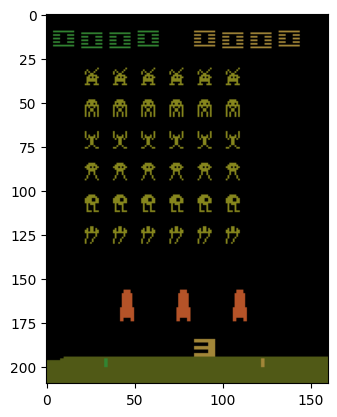

In [6]:
observation, info = env.reset()
plt.imshow(env.render())

In [8]:
%matplotlib inline

import os
import re
import gym
import time
import copy
import random
import warnings
import numpy as np

import torch
import torchvision
import torch.nn as nn

from IPython import display
from skimage import io
#from skimage.color import rgb2grey
from skimage.color import rgb2gray
from skimage.transform import rescale
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
from collections import deque, namedtuple
plt.style.use('seaborn')
warnings.filterwarnings('ignore')

In [18]:
class DeepQNetwork(nn.Module):
    def __init__(self, num_frames, num_actions):
        super(DeepQNetwork, self).__init__()
        self.num_frames = num_frames
        self.num_actions = num_actions
        
        # Layers
        self.conv1 = nn.Conv2d(
            in_channels=num_frames,
            out_channels=16,
            kernel_size=8,
            stride=4,
            padding=2
            )
        self.conv2 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=4,
            stride=2,
            padding=1
            )
        self.fc1 = nn.Linear(
            in_features=3200,
            out_features=256,
            )
        self.fc2 = nn.Linear(
            in_features=256,
            out_features=num_actions,
            )
        
        # Activation Functions
        self.relu = nn.ReLU()
    
    def flatten(self, x):
        batch_size = x.size()[0]
        x = x.view(batch_size, -1)
        return x
    
    def forward(self, x):
        
        # Forward pass
        x = self.relu(self.conv1(x))  # In: (80, 80, 4)  Out: (20, 20, 16)
        x = self.relu(self.conv2(x))  # In: (20, 20, 16) Out: (10, 10, 32)
        x = self.flatten(x)           # In: (10, 10, 32) Out: (3200,)
        x = self.relu(self.fc1(x))    # In: (3200,)      Out: (256,)
        x = self.fc2(x)               # In: (256,)       Out: (4,)
        
        return x

In [19]:
Transition = namedtuple('Transition', ['state', 'action', 'reward', 'terminal', 'next_state'])

In [95]:
class Agent:
    def __init__(self, model, memory_depth, lr, gamma, epsilon_i, epsilon_f, anneal_time, ckptdir):
        
        self.cuda = True if torch.cuda.is_available() else False
        
        self.model = model
        self.device = torch.device("cuda" if self.cuda else "cpu")
        
        if self.cuda:
            self.model = self.model.cuda()
        
        self.memory_depth = memory_depth
        self.gamma = torch.tensor([gamma], device=self.device)
        self.e_i = epsilon_i
        self.e_f = epsilon_f
        self.anneal_time = anneal_time
        self.ckptdir = ckptdir
        
        if not os.path.isdir(ckptdir):
            os.makedirs(ckptdir)
        
        self.memory = deque(maxlen=memory_depth)
        self.clone()
        
        self.loss = nn.SmoothL1Loss()
        self.opt = torch.optim.RMSprop(self.model.parameters(), lr=lr, alpha=0.95, eps=0.01)
        
    def clone(self):
        try:
            del self.clone_model
        except:
            pass
        
        self.clone_model = copy.deepcopy(self.model)
        
        for p in self.clone_model.parameters():
            p.requires_grad = False
        
        if self.cuda:
            self.clone_model = self.clone_model.cuda()
    
    def remember(self, *args):
        self.memory.append(Transition(*args))
    
    def retrieve(self, batch_size):
        transitions = random.sample(self.memory, batch_size)
        batch = Transition(*zip(*transitions))
        state, action, reward, terminal, next_state = map(torch.cat, [*batch])
        return state, action, reward, terminal, next_state
    
    @property
    def memories(self):
        return len(self.memory)
    
    def act(self, state):
        q_values = self.model(state).detach()
        action = torch.argmax(q_values)
        return action.item()
    
    def process(self, state):
        #state=np.asarray(state)
        #print("gg")
        #print(state[0].shape)
        #print(state[0][35:195, :, :])
        #print(typeof(state[35:195, :, :]))
        state = rgb2gray(state[35:195, :, :])#state[0][35:195, :])#
        state = rescale(state, scale=0.5)
        state = state[np.newaxis, np.newaxis, :, :]
        return torch.tensor(state, device=self.device, dtype=torch.float)
    
    def exploration_rate(self, t):
        if 0 <= t < self.anneal_time:
            return self.e_i - t*(self.e_i - self.e_f)/self.anneal_time
        elif t >= self.anneal_time:
            return self.e_f
        elif t < 0:
            return self.e_i
    
    def save(self, t):
        save_path = os.path.join(self.ckptdir, 'model-{}'.format(t))
        torch.save(self.model.state_dict(), save_path)
    
    def load(self):
        ckpts = [file for file in os.listdir(self.ckptdir) if 'model' in file]
        steps = [int(re.search('\d+', file).group(0)) for file in ckpts]
        
        latest_ckpt = ckpts[np.argmax(steps)]
        self.t = np.max(steps)
        
        print("Loading checkpoint: {}".format(latest_ckpt))
        
        self.model.load_state_dict(torch.load(os.path.join(self.ckptdir, latest_ckpt)))
        
    def update(self, batch_size):
        self.model.zero_grad()

        state, action, reward, terminal, next_state = self.retrieve(batch_size)
        q = self.model(state).gather(1, action.view(batch_size, 1))
        qmax = self.clone_model(next_state).max(dim=1)[0]
        
        nonterminal_target = reward + self.gamma*qmax
        terminal_target = reward
        
        target = terminal.float()*terminal_target + (~terminal).float()*nonterminal_target
    
        loss = self.loss(q.view(-1), target)
        loss.backward()
        self.opt.step()

    def play(self, episodes, train=False, load=False, plot=False, render=False, verbose=False):
    
        self.t = 0
        metadata = dict(episode=[], reward=[])
        
        if load:
            self.load()

        try:
            progress_bar = tqdm(range(episodes), unit='episode')
            
            i = 0
            for episode in progress_bar:

                state, info = env.reset()
                state = self.process(state)
                #print(state.shape)
                done = False
                total_reward = 0

                if(render):
                    img = plt.imshow(env.render())
                while not done:

                    if render:
                        img.set_data(env.render())
                        display.display(plt.gcf())
                        display.clear_output(wait=True)

                        
                    #print(state.size()[1])
                    while state.size()[1] < num_frames:
                        action = 1 # Fire
                        #observation, reward, terminated, truncated, info
                        new_frame, reward, done,truncated, info = env.step(action)
                        new_frame = self.process(new_frame)

                        state = torch.cat([state, new_frame], 1)
                    #print("hmm")
                    #print(state.shape)
                    
                    if train and np.random.uniform() < self.exploration_rate(self.t-burn_in):
                        action = np.random.choice(num_actions)

                    else:
                        action = self.act(state)

                    new_frame, reward, done,truncated, info = env.step(action)
                    new_frame = self.process(new_frame)

                    new_state = torch.cat([state, new_frame], 1)
                    new_state = new_state[:, 1:, :, :]
                    
                    if train:
                        reward = torch.tensor([reward], device=self.device, dtype=torch.float)
                        action = torch.tensor([action], device=self.device, dtype=torch.long)
                        done = torch.tensor([done], device=self.device, dtype=torch.uint8)
                        
                        self.remember(state, action, reward, done, new_state)

                    state = new_state
                    total_reward += reward
                    self.t += 1
                    i += 1
                    
                    if not train:
                        time.sleep(0.1)
                    
                    if train and self.t > burn_in and i > batch_size:

                        if self.t % update_interval == 0:
                            self.update(batch_size)

                        if self.t % clone_interval == 0:
                            self.clone()

                        if self.t % save_interval == 0:
                            self.save(self.t)

                    if self.t % 1000 == 0:
                        progress_bar.set_description("t = {}".format(self.t))

                metadata['episode'].append(episode)
                metadata['reward'].append(total_reward)

                if episode % 100 == 0 and episode != 0:
                    avg_return = np.mean(metadata['reward'][-100:])
                    print("Average return (last 100 episodes): {:.2f}".format(avg_return))

                if plot:
                    plt.scatter(metadata['episode'], metadata['reward'])
                    plt.xlim(0, episodes)
                    plt.xlabel("Episode")
                    plt.ylabel("Return")
                    display.clear_output(wait=True)
                    display.display(plt.gcf())
            
            env.close()
            return metadata

        except KeyboardInterrupt:
            if train:
                print("Saving model before quitting...")
                self.save(self.t)
            
            env.close()
            return metadata

In [96]:
# Hyperparameters

batch_size = 32
update_interval = 4
clone_interval = int(1e4)
save_interval = int(1e5)
frame_skip = None
num_frames = 4
num_actions = len(env.unwrapped.get_action_meanings())
episodes = 2#int(1e5)
memory_depth = int(1e5)
epsilon_i = 1.0
epsilon_f = 0.1
anneal_time = int(1e6)
burn_in = int(5e4)
gamma = 0.99
learning_rate = 2.5e-4

In [97]:
model = DeepQNetwork(num_frames, num_actions)
agent = Agent(model, memory_depth, learning_rate, gamma, epsilon_i, epsilon_f, anneal_time, 'ckpt')
#env = gym.make('BreakoutDeterministic-v4')
metadata = agent.play(episodes, train=True, load=False)

  0%|          | 0/2 [00:00<?, ?episode/s]

In [ ]:
metadata


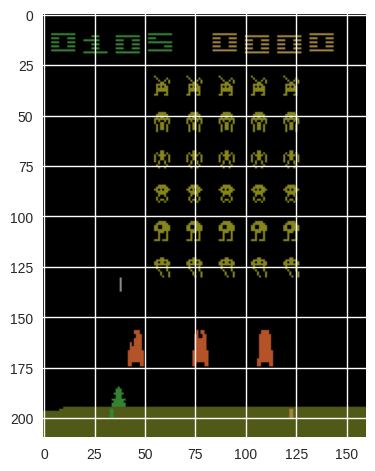

In [ ]:
env = gym.make("ALE/SpaceInvaders-v5", render_mode="rgb_array")
RENDER_WHILE_TRAINING = True

metadata = agent.play(1, train=False, load=False,render=True)


In [ ]:

episodes = 5
for episode in range(1, episodes+1):
    state, info = env.reset()
    done = False
    score = 0 
    
    img = plt.imshow(env.render())
    while not done:
        print("hellpo")
        #env.render("rgb_array")
        if RENDER_WHILE_TRAINING:
            img.set_data(env.render())
            display.display(plt.gcf())
            display.clear_output(wait=True)
        print(state)
        state = agent.process(state)
        print(state.shape)
        action = agent.act(state)#random.choice([0,1,2,3,4,5])
        print(action)
        state, reward, terminated, truncated, info = env.step(action)
        score+=reward
        if terminated or truncated:
            state, info = env.reset()
    print('Episode:{} Score:{}'.format(episode, score))
env.close()

# 2. Create a Deep Learning Model with Keras

In [28]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Convolution2D
from tensorflow.keras.optimizers import Adam

2024-03-14 20:21:37.659779: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [29]:
def build_model(height, width, channels, actions):
    model = Sequential()
    model.add(Convolution2D(32, (8,8), strides=(4,4), activation='relu', input_shape=(3,height, width, channels)))
    model.add(Convolution2D(64, (4,4), strides=(2,2), activation='relu'))
    model.add(Convolution2D(64, (3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [11]:
del model

In [23]:
model = build_model(height, width, channels, actions)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 3, 51, 39, 32)     6176      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 3, 24, 18, 64)     32832     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 22, 16, 64)     36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 67584)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               34603520  
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_11 (Dense)             (None, 6)                

# 3. Build Agent with Keras-RL

In [14]:
from rl.agents import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy

In [17]:
def build_agent(model, actions):
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.2, nb_steps=10000)
    memory = SequentialMemory(limit=1000, window_length=3)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                  enable_dueling_network=True, dueling_type='avg', 
                   nb_actions=actions, nb_steps_warmup=1000
                  )
    return dqn

In [25]:
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-4))

In [18]:
dqn.fit(env, nb_steps=10000, visualize=False, verbose=2)

Training for 10000 steps ...
 1197/10000: episode: 1, duration: 16.708s, episode steps: 1197, steps per second:  72, episode reward: 275.000, mean reward:  0.230 [ 0.000, 30.000], mean action: 2.595 [0.000, 5.000],  loss: 27.396054, mean_q: 11.414030, mean_eps: 0.901135
 1890/10000: episode: 2, duration: 41.929s, episode steps: 693, steps per second:  17, episode reward: 135.000, mean reward:  0.195 [ 0.000, 30.000], mean action: 2.505 [0.000, 5.000],  loss: 1.129293, mean_q: 9.534999, mean_eps: 0.861130
 2441/10000: episode: 3, duration: 34.082s, episode steps: 551, steps per second:  16, episode reward: 140.000, mean reward:  0.254 [ 0.000, 30.000], mean action: 2.566 [0.000, 5.000],  loss: 1.161340, mean_q: 10.541823, mean_eps: 0.805150
 3449/10000: episode: 4, duration: 61.689s, episode steps: 1008, steps per second:  16, episode reward: 320.000, mean reward:  0.317 [ 0.000, 30.000], mean action: 2.569 [0.000, 5.000],  loss: 1.287153, mean_q: 11.357870, mean_eps: 0.734995
 4513/100

In [27]:
scores = dqn.test(env, nb_episodes=10, visualize=True)
print(np.mean(scores.history['episode_reward']))

Testing for 10 episodes ...
Episode 1: reward: 90.000, steps: 499
Episode 2: reward: 220.000, steps: 965
Episode 3: reward: 230.000, steps: 1224
Episode 4: reward: 240.000, steps: 715
Episode 5: reward: 635.000, steps: 1267
Episode 6: reward: 205.000, steps: 673
Episode 7: reward: 435.000, steps: 1096
Episode 8: reward: 315.000, steps: 1166
Episode 9: reward: 170.000, steps: 679
Episode 10: reward: 280.000, steps: 871
282.0


# 4. Reloading Agent from Memory

In [21]:
dqn.save_weights('SavedWeights/10k-Fast/dqn_weights.h5f')

In [22]:
del model, dqn

In [26]:
dqn.load_weights('SavedWeights/1m/dqn_weights.h5f')